# CREDIT TO THE MODULE EXAMPLE:
# DepthAI Tutorial: Training a Tiny Yolov3 Object Detector with Your Own Data

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">



## STEP 1 Install Darknet


In [1]:
%%capture
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [4]:
#utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  


## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint. 
Changes to some files need to be made according to own data, but it is nothing complicated.

In [5]:
repo_url = 'https://github.com/Elkayamacc/DeepCourse.git'
import os
%cd /content
!git clone {repo_url}
%cd DeepCourse/


/content
Cloning into 'DeepCourse'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 47 (delta 5), reused 7 (delta 2), pack-reused 31
Unpacking objects: 100% (47/47), done.
/content/DeepCourse


### Now go to the file explorer on the left of the colab notebook and click on content then on the yolotinyv3_medmask_demo folder.
Here you will see a folder and a few files.
The `obj` folder contains both images AND the associated annotations in yolo format. 

(to annotate own images use https://github.com/tzutalin/labelImg and save annotations in yolo format)

* the 'obj.data' file contains paths for files used by Darknet and the number of classes to train the yolo model.

* the 'obj.names' file has the labels of the objects to be detected. the number of objects gives the number of classes in the 'obj.data' file.

* the train.txt contains the path to each image to be used in training. similarly, test.txt contains the path to each image for testing. when not many images are available for training (a few hundred), use all images for training for better model performance. for the mask model we have 40 images for testing and 638 images for training. 

* the yolov3-tiny.conv.15 are the COCO pretrained weights 

* the yolov3-tiny_obj.cfg are is the tiny yolov3 configuration file that tells Darknet the model parameters and structure

So we can see that all these files need to be changed according to own data.


# How to use your own images
In order to use your own annotated images, follow the steps below. If you want to train on the images already in the repo, skip this section and jump to the Train model section.

## Let's start with the images and annotations. I will use my images as example.
We copy the images on our google drive in a folder. My gdrive folder is named medmask_yolo. Then we mount the gdrive in colab and copy the images and annotations in the obj folder.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%rm -rf /content/DeepCourse/obj/
#make dir obj
!mkdir /content/DeepCourse/obj/
!cp -rf '/content/DeepCourse/obj1.zip' '/content/DeepCourse/obj/'
!cp -rf '/content/DeepCourse/obj2.zip' '/content/DeepCourse/obj/'

In [9]:
!unzip /content/DeepCourse/obj/obj1.zip -d /content/DeepCourse/obj/
!unzip /content/DeepCourse/obj/obj2.zip -d /content/DeepCourse/obj/

Streaming output truncated to the last 5000 lines.
  inflating: /content/DeepCourse/obj/maksssksksss314_png.rf.9df37b0acf81d72959caea8eb12ba00e.txt  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.31054af7130c0daf436d5eb6096044a0.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.31054af7130c0daf436d5eb6096044a0.txt  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.9d2e19c9ab3477807cae4f4c64941651.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.9d2e19c9ab3477807cae4f4c64941651.txt  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.f8acefc8e8ae5715cda97d35606f2f1e.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss315_png.rf.f8acefc8e8ae5715cda97d35606f2f1e.txt  
  inflating: /content/DeepCourse/obj/maksssksksss316_png.rf.324ae96261fbe3733d850e4fbe92e5c1.jpg  
  inflating: /content/DeepCourse/obj/maksssksksss316_png.rf.324ae96261fbe3733d850e4fbe92e5c1.txt  
  inflating: /content/DeepCourse/obj/maksssksksss316_png.r

## Change the labels in obj.names to our current labels

In [10]:
labels_path = '/content/DeepCourse/obj/obj.names'
#make a list of your labels
labels = ['no mask','mask']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/DeepCourse/obj/obj.names

no mask
mask

## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [11]:
import re
objdata = '/content/DeepCourse/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/DeepCourse/obj.data

classes= 2
train  = /content/DeepCourse/train.txt
valid  = /content/DeepCourse/valid.txt
names = /content/DeepCourse/obj.names
backup = backup/

## Now we need to create a train.txt and test.txt file for our images from `obj` folder.
We will use a script that splits the images based on a specified percentage 
and writes them in train.txt and test.txt files.

In [12]:
%cd /content/DeepCourse

/content/DeepCourse


In [13]:
#in this case we use 6 percent as the number of images for testing.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
!python3 folder2textYolo.py 75 20  /content/DeepCourse/obj

Your image file extension is: .jpg
Number of images: 2831
Number of images used for training 2123
Number of images used for validation 566
Number of images used for testing 142


## Last thing we need to change is the yolov3-tiny_obj.cfg file.
There are several parameters of importance here. They control various aspects of the training process. Let's print the first few lines and have a look


In [14]:
!head -n 24 /content/DeepCourse/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



### Let's go over the parameters above:
* The batch parameter dictates the batch size. That one generally remains at 64.
* The subdivisions dictates how many images are loaded into memory. A smaller number translates to faster training. We will use 12. If a CUDA out of memory error is triggered, the subdivisions should be increased to i.e. 16,24,32 or some other number. (64 is max) Unless training with a resolution higher than 416, there should be no problem with 12.
* The width and height are by default at 416. Another resolution one can try is 320, or 608.
* The next parameter we care about is max_batches. This determines how long the training process is. Its value should be at least around 2000 for every class used. So for 3 classes, at least 6000.
* The steps are calculated as a function of max_batches. The first value is 0.8 * max_batches and the second value 0.9 * max_batches. In this case it is 8000 * 0.8 and 8000 * 0.9. 

For more details about Yolo parameters have a look here:
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects
There is a lot of material here, so make sure you scroll through if you have questions. Pretty much everything is well explained.




### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [15]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

num_classes = len(labels)
num_filters = (num_classes + 5) * 3 


cfg_file = '/content/DeepCourse/yolov3-tiny_obj.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



Let's look again at the configuration 

In [16]:
!head -n 24 /content/DeepCourse/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



We also check if the number of classes and filters updated correctly

In [17]:
!tail -n 64 /content/DeepCourse/yolov3-tiny_obj.cfg 


stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


# Train the model

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

In the `content/darknet/backup/` folder Darknet saves a few weights files:
* files that end in 1000,2000 etc are weights saved every 1000 batches
* best weights file are the weights that gave best results during training
* final weights file contains the final weights at the end of the training





## Start the model training

In [17]:
%cd ../darknet/

/content/darknet


In [18]:
!./darknet detector train /content/DeepCourse/obj.data /content/DeepCourse/yolov3-tiny_obj.cfg /content/DeepCourse/yolov3-tiny.conv.15 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.760920), count: 8, class_loss = 0.648325, iou_loss = 0.267901, total_loss = 0.916226 
 total_bbox = 891661, rewritten_bbox = 0.055851 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.827007), count: 7, class_loss = 0.162410, iou_loss = 0.157190, total_loss = 0.319600 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.740213), count: 27, class_loss = 3.251569, iou_loss = 1.576080, total_loss = 4.827649 
 total_bbox = 891695, rewritten_bbox = 0.055849 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 16 Avg (IOU: 0.766357), count: 4, class_loss = 0.046957, iou_loss = 0.147357, total_loss = 0.194314 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 23 Avg (IOU: 0.781286), count: 9, class_loss = 0.338679, iou_loss = 0.461762, total_loss = 0.800441 
 total

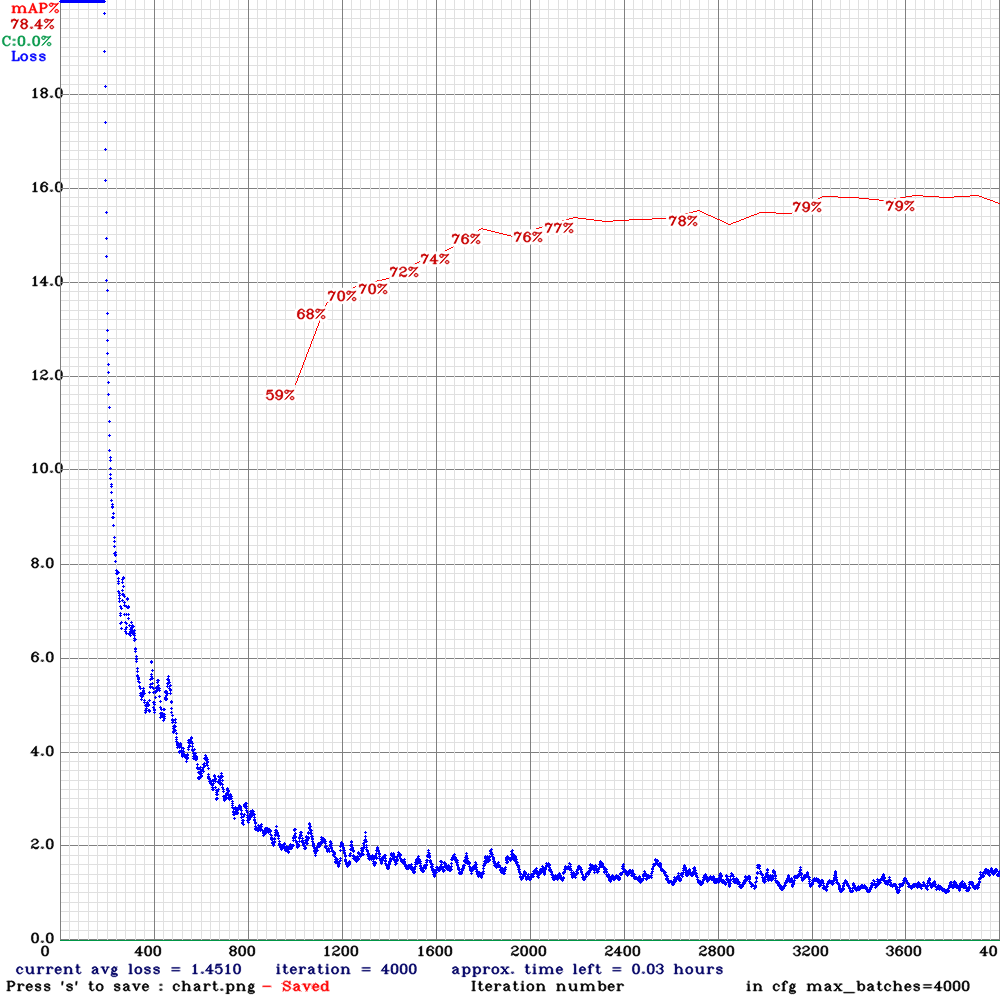

In [19]:
#Chart
from IPython.display import Image
Image('/content/darknet/chart_yolov3-tiny_obj.png')

## Check the model performance
The metrics run on the test images so they may not be fully representative, only indicative

In [20]:
!./darknet detector map /content/DeepCourse/obj.data /content/DeepCourse/yolov3-tiny_obj.cfg "/content/darknet/backup/yolov3-tiny_obj_best.weights" -map -points 0

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 

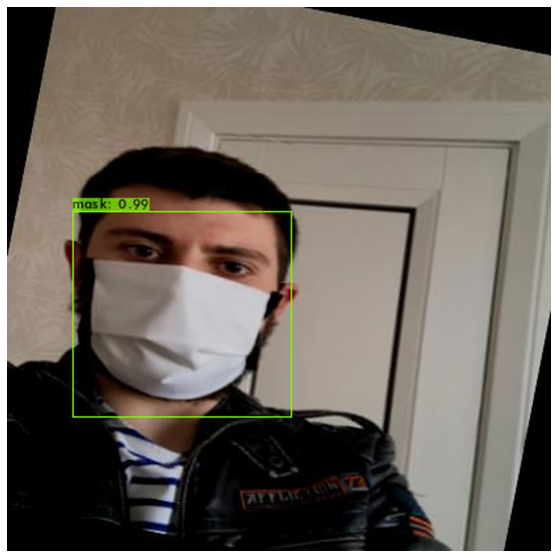

In [21]:
!./darknet detector test /content/DeepCourse/obj.data  /content/DeepCourse/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_best.weights" /content/DeepCourse/obj/maksssksksss520_png.rf.f9770290d76a015ff5deb743e14703a7.jpg -ext_output -map
imShow('predictions.jpg')

## Copy best weights to google drive


In [23]:
!cp /content/darknet/backup/*  '/content/drive/MyDrive/Tinyyolo/Tiny3BestWeights'

Convert the best yolo weights to Tensorflow frozen model. 
The name and location of the frozen model is


 `/content/tensorflow-yolo-v3/frozen_darknet_yolov3_model.pb`

## Run Detection on Video to test

In [27]:
%cp -r '/content/darknet/chart_yolov3-tiny_obj.png' '/content/drive/MyDrive/Tinyyolo/Predictions/'

In [33]:
cd darknet/

/content/darknet


In [34]:
!wget -O test.mp4 "https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4"

--2021-02-05 18:41:51--  https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4 [following]
--2021-02-05 18:41:51--  https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ibaiGorordo/Social-Distance-

In [35]:
!./darknet detector demo /content/DeepCourse/obj.data  /content/DeepCourse/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_best.weights" -dont_show test.mp4 -i 0 -out_filename results.avi

Streaming output truncated to the last 5000 lines.


FPS:19.8 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:

no mask: 29% 

FPS:19.9 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:20.2 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:19.5 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:19.2 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:19.1 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:20.1 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:21.2 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:21.9 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:22.7 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:23.4 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:23.4 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:


FPS:23.8 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:

mask: 37% 

FPS:23.4 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:

mask: 30% 

FPS:22.4 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:

mask: 30% 

FPS:21.7 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:

mask: 50% 

FPS:21.3 	 AVG_FPS:21.4

 cvWriteFrame 
Objects:

mask: 39% 

FPS:20.8 	 

In [36]:
# download the video with detections shown
from google.colab import files

video_path = 'results.avi'
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>